# Introduction

## Background

-  Bosanac, N.: Leveraging Natural Dynamical Structures to Explore Multi-Body Systems. PhD Dis-
sertation, Purdue University, West Lafayette, IN (2016)
- Das-Stuart, A., Howell, K.C., Folta, D.C.: Rapid trajectory design in complex environments enabled
by reinforcement learning and graph search strategies. Acta Astronaut. 171, 172–195 (2020)
- Gómez, G., Koon, W.S., Lo, M.W., Marsden, J.E., Masdemont, J., Ross, S.D.: Connecting orbits
and invariant manifolds in the spatial restricted three-body problem. Nonlinearity 17, 1571–1606
(2004)
- Koon, W.S., Lo, M.W., Marsden, J.E., Ross, S.D.: Dynamical Systems, The Three-Body Problem,
and Space Mission Design. Springer, New York, USA (2011)
- Smith, T.R., Bosanac, N.: A Motion Primitive Approach to Trajectory Design in a Multi-Body Sys-
tem. In: AAS/AIAA Astrodynamics Specialist Conference. Charlotte, NC (2022)
- Smith, T.R., Bosanac, N.: Constructing motion primitive sets to summarize periodic orbit families
and hyperbolic invariant manifolds in a multi-body system. Celest. Mech. Dyn. Astron. 134(1), 7
(2022)

## To Do

1. Construct a motion primitive library that summarizes the characteristics of arcs
that exist within segments of the solution space.
2. Construct a motion primitive graph that discretely approximates a subset of the
continuous solution space.
3. Search the graph for motion primitive sequences that serve as candidates for initial
guesses for trajectories.
4. Construct an initial guess for each trajectory by refining each motion primitive
sequence.
5. Correct each initial guess to produce a continuous trajectory with impulsive
maneuvers using direct collocation and local optimization.
6. Compute additional transfers spanning segments of the design space.
7. Look into graph search/machine learning methods for stitching together arcs


 -  looked into symplectic integrators, juice not worth the squeeze on small timescales 

# Initialization

## Imports

In [4]:
import sys
import os
import random
import math

import numpy as np 
from numpy import cos, sin
import matplotlib
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.graph_objects as go

import pickle as pkl
import PIL.Image as Image



from PIL import Image
import copy
import seaborn as sns
from scipy.integrate import odeint
from scipy.integrate import solve_ivp




import gym
from gym import Env, spaces
import time
import operator



from datetime import datetime
import navpy as nav


from poliastro.bodies import Sun, Earth, Moon
from poliastro.ephem import Ephem
from poliastro.frames import Planes
from poliastro.plotting import StaticOrbitPlotter
from poliastro.plotting.misc import plot_solar_system
from poliastro.twobody import Orbit
from poliastro.util import norm, time_range
from poliastro.constants import J2000
from poliastro.plotting import OrbitPlotter3D
from poliastro.plotting import OrbitPlotter2D
from poliastro.twobody.sampling import EpochsArray, TrueAnomalyBounds, EpochBounds
from poliastro.maneuver import Maneuver
from poliastro.twobody.propagation import propagate, cowell
from poliastro import constants



from astropy import units as u
from astropy.time import Time, TimeDelta
from astropy.utils.data import conf
from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric, get_body

from astroquery.jplhorizons import Horizons

conf.dataurl
conf.remote_timeout = 10000
solar_system_ephemeris.set("jpl")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
from torch.distributions import Normal
from torch.autograd import gradcheck
import torch.nn.init as init
from torch.nn.utils import clip_grad_norm_, clip_grad_value_



In [5]:
from captum.attr import LayerIntegratedGradients
from captum.attr import Saliency
from torchviz import make_dot


from IPython.display import clear_output
import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from math import sqrt
from scipy.optimize import fsolve

import rebound
import sympy as sp

## Symbolic Equation Derivation

In [6]:
X, Y, Z, u2 = sp.symbols('X Y Z u2')
#Set up the symbolic representation of the potential
r1 = ((u2+X)**2 + Y**2 + Z**2)**(1/2)
r2 = ((X - 1 + u2)**2 + Y**2 + Z**2)**(1/2)
U = (1-u2)/r1 + u2/r2 + (1/2)*(X**2 + Z**2)

#Take double partials wrt all coordinates
coordlist = [X, Y, Z]
for i in coordlist:
    for j in coordlist:
        PPU = sp.diff(U, i, j)
        print("U",i,j, " = ", PPU)
        print('___________________________________________________________________________________')

U X X  =  3.0*u2*(X + u2 - 1)**2/(Y**2 + Z**2 + (X + u2 - 1)**2)**2.5 - 1.0*u2/(Y**2 + Z**2 + (X + u2 - 1)**2)**1.5 - 3.0*(X + u2)**2*(u2 - 1)/(Y**2 + Z**2 + (X + u2)**2)**2.5 + 1.0*(u2 - 1)/(Y**2 + Z**2 + (X + u2)**2)**1.5 + 1.0
___________________________________________________________________________________
U X Y  =  3.0*Y*(u2*(X + u2 - 1)/(Y**2 + Z**2 + (X + u2 - 1)**2)**2.5 - (X + u2)*(u2 - 1)/(Y**2 + Z**2 + (X + u2)**2)**2.5)
___________________________________________________________________________________
U X Z  =  3.0*Z*(u2*(X + u2 - 1)/(Y**2 + Z**2 + (X + u2 - 1)**2)**2.5 - (X + u2)*(u2 - 1)/(Y**2 + Z**2 + (X + u2)**2)**2.5)
___________________________________________________________________________________
U Y X  =  3.0*Y*(u2*(X + u2 - 1)/(Y**2 + Z**2 + (X + u2 - 1)**2)**2.5 - (X + u2)*(u2 - 1)/(Y**2 + Z**2 + (X + u2)**2)**2.5)
___________________________________________________________________________________
U Y Y  =  3.0*Y**2*u2/(Y**2 + Z**2 + (X + u2 - 1)**2)**2.5 - 3

In [ ]:
-X + (u1*(u2+X))/((u2+X)**2 + Y**2 + Z**2)**(3/2) + u2*(X - 1 + u2)/((X - u1)**2 + Y**2 + Z**2)**(3/2)

In [4]:

stm = np.eye(6)
#Construct elements (1,1) through (3,3) of matrix A (Upper Left)
Aul = np.array([[0 for _ in range(3)] for _ in range(3)])
#Construct elements (1,4) through (3,6) of matrix A (Upper Right)
Aur = np.eye(3)
#Construct elements (4,1) through (6,3) of matrix A (Lower Left)
UXX  =  1
UXY  =  2
UXZ  =  3
UYX  =  4
UYY  =  5
UYZ  =  6
UZX  =  7
UZY  =  8
UZZ  =  9
All = np.array([
    [UXX, UXY, UXZ],
    [UYX, UYY, UYZ],
    [UZX, UZY, UZZ]
])
#Construct elements (4,4) through (6,6) of matrix A (Lower Right)
Alr = np.array([
    [0, 2, 0],
    [-2, 0, 0],
    [0, 0, 0]
])   



Atop = np.hstack((Aul,Aur))
Abot = np.hstack((All,Alr))

A = np.vstack((Atop,Abot))

stm_dot = A @ stm
print(stm_dot)
stm_dot = stm_dot.flatten()

print(stm_dot)
stm_dot = np.reshape(stm_dot, (6, 6))
print(stm_dot)

[[ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.]
 [ 1.  2.  3.  0.  2.  0.]
 [ 4.  5.  6. -2.  0.  0.]
 [ 7.  8.  9.  0.  0.  0.]]
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.
  1.  2.  3.  0.  2.  0.  4.  5.  6. -2.  0.  0.  7.  8.  9.  0.  0.  0.]
[[ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.]
 [ 1.  2.  3.  0.  2.  0.]
 [ 4.  5.  6. -2.  0.  0.]
 [ 7.  8.  9.  0.  0.  0.]]


## Functions

In [40]:
def f(x, coeffs):
    """
    Compute the value of the quintic polynomial at x.
    coeffs: List of coefficients [a, b, c, d, e, f]
    """
    a, b, c, d, e, f = coeffs
    return a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x + f

def f_prime(x, coeffs):
    """
    Compute the derivative of the quintic polynomial at x.
    coeffs: List of coefficients [a, b, c, d, e, f]
    """
    a, b, c, d, e, f = coeffs
    return 5*a*x**h4 + 4*b*x**3 + 3*c*x**2 + 2*d*x + e

def newtons_method(coefficients, initial_guess, tolerance=1e-17, max_iterations=100000000):
    x = initial_guess
    for _ in range(max_iterations):
        f_value = f(x, coefficients)
        f_prime_value = f_prime(x, coefficients)
        x = x - f_value / f_prime_value
        if abs(f_value) < tolerance:
            return x
    raise Exception("Newton's method did not converge")


def ECI_2_MFR_DCM(r_m, v_m, r_s):
    r_m_q = []
    r_s_q = []
    Q_ = []
    
    for n in range(0, r_m.shape[1]):
        x = r_m[:, n]
        z = np.cross(x, v_m[:, n])
        y = np.cross(z, x)

        i_ = x/np.linalg.norm(x)
        j_ = y/np.linalg.norm(y)
        k_ = z/np.linalg.norm(z)

        Q = [i_.T, j_.T, k_.T]

        Q_.append(Q)
        r_m_q.append(Q@r_m[:,n])
        r_s_q.append(Q@r_s[:,n])

    r_m_q = np.array(r_m_q)
    r_s_q = np.array(r_s_q)
    Q_ = np.array(Q_)        
        
    return Q_, r_m_q, r_s_q

def lunar_Orbit_DEQ_rotating(t, x):
    #Calculate the mass ratio for the two bodies
    M_earth = 5.972e24
    M_moon = 7.342e22

    u2 = M_moon/(M_earth+M_moon)
    u1 = 1-u2
    
    #Extract the position components from the state vector
    X = x[0]
    Y = x[1]
    Z = x[2]
 
    X_dot = x[3]
    Y_dot = x[4]
    Z_dot = x[5]
    
    #Reconstitute stm shape
    stm = x[6:]
    stm = np.reshape(stm, (6, 6))

    #Construct elements (1,1) through (3,3) of matrix A (Upper Left)
    Aul = np.array([[0 for _ in range(3)] for _ in range(3)])
    #Construct elements (1,4) through (3,6) of matrix A (Upper Right)
    Aur = np.eye(3)
    #Construct elements (4,1) through (6,3) of matrix A (Lower Left)
    UXX  =  3.0*u2*(X + u2 - 1)**2/(Y**2 + Z**2 + (X + u2 - 1)**2)**2.5 - 1.0*u2/(Y**2 + Z**2 + (X + u2 - 1)**2)**1.5 - 3.0*(X + u2)**2*(u2 - 1)/(Y**2 + Z**2 + (X + u2)**2)**2.5 + 1.0*(u2 - 1)/(Y**2 + Z**2 + (X + u2)**2)**1.5 + 1.0
    UXY  =  3.0*Y*(u2*(X + u2 - 1)/(Y**2 + Z**2 + (X + u2 - 1)**2)**2.5 - (X + u2)*(u2 - 1)/(Y**2 + Z**2 + (X + u2)**2)**2.5)
    UXZ  =  3.0*Z*(u2*(X + u2 - 1)/(Y**2 + Z**2 + (X + u2 - 1)**2)**2.5 - (X + u2)*(u2 - 1)/(Y**2 + Z**2 + (X + u2)**2)**2.5)
    UYX  =  3.0*Y*(u2*(X + u2 - 1)/(Y**2 + Z**2 + (X + u2 - 1)**2)**2.5 - (X + u2)*(u2 - 1)/(Y**2 + Z**2 + (X + u2)**2)**2.5)
    UYY  =  3.0*Y**2*u2/(Y**2 + Z**2 + (X + u2 - 1)**2)**2.5 - 3.0*Y**2*(u2 - 1)/(Y**2 + Z**2 + (X + u2)**2)**2.5 - 1.0*u2/(Y**2 + Z**2 + (X + u2 - 1)**2)**1.5 + 1.0*(u2 - 1)/(Y**2 + Z**2 + (X + u2)**2)**1.5
    UYZ  =  3.0*Y*Z*(u2/(Y**2 + Z**2 + (X + u2 - 1)**2)**2.5 - (u2 - 1)/(Y**2 + Z**2 + (X + u2)**2)**2.5)
    UZX  =  3.0*Z*(u2*(X + u2 - 1)/(Y**2 + Z**2 + (X + u2 - 1)**2)**2.5 - (X + u2)*(u2 - 1)/(Y**2 + Z**2 + (X + u2)**2)**2.5)
    UZY  =  3.0*Y*Z*(u2/(Y**2 + Z**2 + (X + u2 - 1)**2)**2.5 - (u2 - 1)/(Y**2 + Z**2 + (X + u2)**2)**2.5)
    UZZ  =  3.0*Z**2*u2/(Y**2 + Z**2 + (X + u2 - 1)**2)**2.5 - 3.0*Z**2*(u2 - 1)/(Y**2 + Z**2 + (X + u2)**2)**2.5 - 1.0*u2/(Y**2 + Z**2 + (X + u2 - 1)**2)**1.5 + 1.0*(u2 - 1)/(Y**2 + Z**2 + (X + u2)**2)**1.5 + 1.0
    All = np.array([
        [UXX, UXY, UXZ],
        [UYX, UYY, UYZ],
        [UZX, UZY, UZZ]
    ])
    #Construct elements (4,4) through (6,6) of matrix A (Lower Right)
    Alr = np.array([
        [0, 2, 0],
        [-2, 0, 0],
        [0, 0, 0]
    ])   



    Atop = np.hstack((Aul,Aur))
    Abot = np.hstack((All,Alr))

    A = np.vstack((Atop,Abot))

    stm_dot = A @ stm

    stm_dot = stm_dot.flatten()

    #Calculate the partials of the Effective Potential wrt the x,y,z
    U_barx = -X + (u1*(u2+X))/((u2+X)**2 + Y**2 + Z**2)**(3/2) + u2*(X - 1 + u2)/((X - u1)**2 + Y**2 + Z**2)**(3/2)
    U_bary = -Y + (u1*Y)/((u2+X)**2 + Y**2 + Z**2)**(3/2) + (u2*Y)/((X - u1)**2 + Y**2 + Z**2)**(3/2)
    U_barz = (u1*Z)/((u2+X)**2 + Y**2 + Z**2)**(3/2) + (u2*Z)/((X - u1)**2 + Y**2 + Z**2)**(3/2)
    
    
    #Calculate the acceleration according to the Euler-Lagrange equations
    ax = -U_barx + 2*Y_dot
    ay = -U_bary - 2*X_dot 
    az = -U_barz
    
    dxdt = [X_dot, Y_dot, Z_dot, ax, ay, az]
    DEQ = np.concatenate((dxdt, stm_dot))

    return DEQ

def plot_2body_scale(sol):
    #Extract Satellite position components
    x_s = sol.y[0,:]
    y_s = sol.y[1,:]


    #Extract Satellite position Vector
    r_s = sol.y[0:3,:]


    plt.plot(x_s, y_s)
    plt.xlim(-.2, 1.5)
    # plt.ylim(-.2, .2)
    # plt.axis('equal')
    x_points = [-u2, u1, L1, L2]
    y_points = [0, 0, 0 ,0]

    labels = ['Earth', 'Moon', 'L1', 'L2']
    plt.scatter(x_points[0], y_points[0], color='Blue')
    plt.scatter(x_points[1:], y_points[1:], color='Red')
    for label, x_val, y_val in zip(labels, x_points, y_points):
        plt.text(x_val, y_val, label, fontsize=12, ha='left')

    plt.axis('equal')



def plot_1body_scale(sol):
    #Extract Satellite position components
    x_s = sol.y[0,:]
    y_s = sol.y[1,:]
    
    plt.plot(x_s, y_s)
    plt.xlim(.8, 1)
    plt.ylim(-.2, .2)
    
    x_points = [ u1, L1, L2]
    y_points = [0, 0 ,0]

    labels = ['Moon', 'L1', 'L2']
    plt.scatter(x_points[0], y_points[0], color='Blue')
    plt.scatter(x_points[1:], y_points[1:], color='Red')
    for label, x_val, y_val in zip(labels, x_points, y_points):
        plt.text(x_val, y_val, label, fontsize=12, ha='left')

def  plot_xe_scale(sol, xe): 
    #Extract Satellite position components
    x_s = sol.y[0,:]
    y_s = sol.y[1,:]
    
    plt.plot(x_s, y_s)
    plt.xlim(xe - .01, xe + .01)
    plt.ylim(-.01, .01)
    
    x_points = [ mu, L1, L2]
    y_points = [0, 0 ,0]

    labels = ['Moon', 'L1', 'L2']
    plt.scatter(xe, 0, color='Blue')
    
    plt.text(xe, 0, "L", fontsize=12, ha='left')
        
def collinear_lagrange(xg, mu):


    first_term = xg
    second_term = (1 - mu) / np.abs(xg + mu)**3 * (xg + mu)
    third_term = mu / np.abs(xg - 1 + mu)**3 * (xg - 1 + mu)
    return first_term - second_term - third_term  

def Analytical_Guesses(xe, As):
    x_0s = []

    #Changing coordinates to (xe,0,0,xe), the mass ratio becomes
    u_bar = mu*abs(xe-1+mu)**(-3) + (1-mu)*abs(xe+mu)**(-3)

    v = .5*(u_bar-2+sqrt(9*u_bar**2 - 8*u_bar))

    tau = -(v**2 + 2*u_bar + 1)/(2*v)
    print(v)
    print(tau)
    
    if isinstance(As, (int, float)): 
        y_0 = -As*v*tau
        x_0 = [xe - As, 0, 0, 0, y_0, 0]

        return x_0
    
    elif isinstance(As, (list, np.ndarray)):  # Check if x is a list of values
        for A in As:
            y_0 = -A*v*tau
            x_0 = [xe - A, 0, 0, 0, y_0, 0]
            x_0s.append(x_0)  
        x_0s = np.array(x_0s)
        return x_0s

def Correct_to_PO(x_0s, xe, d):
    x_0s_corrected = []
    x_1s_corrected = []
    stm_0s_corrected = []
    stm_1s_corrected = []
    for x_0 in x_0s:

        x_0 = np.concatenate((x_0, stm_0))
        vx = 1
        count = 0

        while abs(vx) > d:

            if x_0[4] > 0:
                y_cross.direction = -1
            elif x_0[4] < 0:
                y_cross.direction = 1

            t_span = (0, 2*np.pi)
            t = np.linspace(t_span[0], t_span[1], num=50000)    
            sol = solve_ivp(lunar_Orbit_DEQ_rotating, t_span, x_0,t_eval=t, dense_output='True', method = 'LSODA', events=y_cross, rtol=1e-10, atol=1e-14 )
            #Extract STM and Velocities
            stms = sol.y[6:,:]

            vy = sol.y[4,:][-1]
            vx = sol.y[3,:][-1]
            xs = sol.y[:6,:]
            stm = stms[:,-1]

            #Reshape STM to matrix form for interpretable reference
            stm = np.reshape(stm, (6, 6))

            dvy_0 = ((stm[3,4] - (1/vy)*stm[2,4])**-1)*vx

            x_0[4] -= dvy_0

            count+=1


            if count > 30:
                print("Solution for xe = ", xe - x_0[0],  " Not Found")
                break
                

        t_span = (0, 2*sol.t[-1])
        t = np.linspace(t_span[0], t_span[1], num=2*50000)    
        sol = solve_ivp(lunar_Orbit_DEQ_rotating, t_span, x_0,t_eval=t, dense_output='True', method = 'LSODA', rtol=1e-10, atol=1e-14 )
        #Extract STM and Velocities
        stms = sol.y[6:,:]
        xs = sol.y[:6,:]     

        stm = stms[:,-1]
            
        x_0s_corrected.append(x_0[:6])
        stm_0s_corrected.append(x_0[6:])
        x_1s_corrected.append(xs[:,-1])
        stm_1s_corrected.append(stms[:,-1])
        


        plot_xe_scale(sol, xe)
    return np.array(x_0s_corrected),np.array(x_1s_corrected), np.array(stm_0s_corrected), np.array(stm_1s_corrected), t

## Differential Corrector Functions

In [53]:
def get_acceleration(x):

    #Extract the position components from the state vector
    X = x[0]
    Y = x[1]
    Z = x[2]
 
    X_dot = x[3]
    Y_dot = x[4]
    Z_dot = x[5]
    
    #Calculate the partials of the Effective Potential wrt the x,y,z
    U_barx = -X + (u1*(u2+X))/((u2+X)**2 + Y**2 + Z**2)**(3/2) + u2*(X - 1 + u2)/((X - u1)**2 + Y**2 + Z**2)**(3/2)
    U_bary = -Y + (u1*Y)/((u2+X)**2 + Y**2 + Z**2)**(3/2) + (u2*Y)/((X - u1)**2 + Y**2 + Z**2)**(3/2)
    U_barz = (u1*Z)/((u2+X)**2 + Y**2 + Z**2)**(3/2) + (u2*Z)/((X - u1)**2 + Y**2 + Z**2)**(3/2)
    
    
    #Calculate the acceleration according to the Euler-Lagrange equations
    ax = -U_barx + 2*Y_dot
    ay = -U_bary - 2*X_dot 
    az = -U_barz
    
    a = [ax, ay, az]
    
    return a

# CR3BP Periodic Orbit Cataloging

In [9]:
M_earth = 5.972e24
M_moon = 7.342e22

mu = M_moon/(M_earth+M_moon)


## Finding Lagrange Points

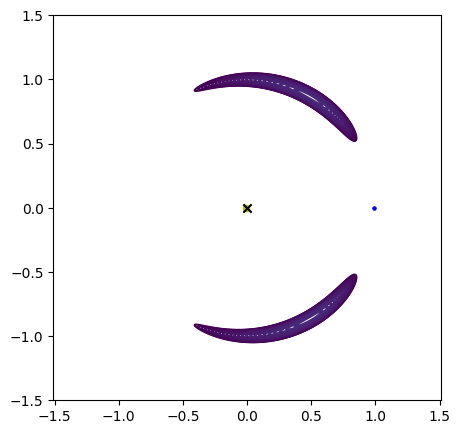

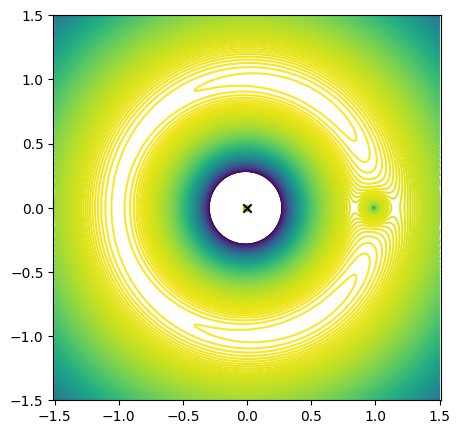

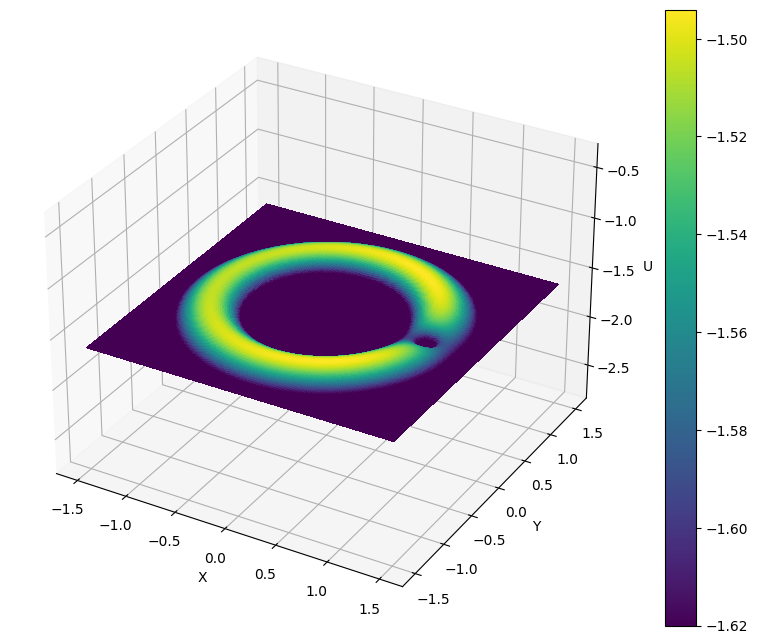

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, fixed

# mu = u
R = 1
sun_pos = np.array([-mu*R, 0])
earth_pos = np.array([(1-mu)*R, 0])

N = 1000
x, y = np.meshgrid(np.linspace(-1.5, 1.5, N), np.linspace(-1.5, 1.5, N))

term1 = -(1-mu) / ((x + mu)**2 + y**2)**0.5
term2 = -mu / ((x - (1-mu))**2 + y**2)**0.5
term3 = -0.5 * (x**2 + y**2)

u = term1 + term2 + term3

plt.figure(figsize=(5, 5))
levels = np.linspace(-1.5, -1.45, 200)
plt.contour(x, y, u, levels=levels)
plt.scatter([sun_pos[0]], [sun_pos[1]], c='y', s=20)
plt.scatter([earth_pos[0]], [earth_pos[1]], c='b', s=5)
plt.scatter([0], [0], c='k', marker='x')
plt.axis('equal')

plt.figure(figsize=(5, 5))
levels = np.linspace(-3.5, -1.5, 200)
plt.contour(x, y, u, levels=levels)
plt.scatter([sun_pos[0]], [sun_pos[1]], c='y', s=20)
plt.scatter([earth_pos[0]], [earth_pos[1]], c='b', s=5)
plt.scatter([0], [0], c='k', marker='x')
plt.axis('equal')


u = np.where(u <= -1.62, -1.62, u)

# Create 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, u, cmap='viridis',  rstride=5, cstride=5, antialiased=False)



# Add labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('U')


# Add colorbar
fig.colorbar(surf)

plt.axis('equal')

# Show the plot
plt.show()

In [11]:
from scipy.optimize import newton

#Define the m1-m2 ratio, mu
mu = M_moon/(M_earth+M_moon)


L2 = newton(func=collinear_lagrange, x0=1, args=(mu,))
L1 = newton(func=collinear_lagrange, x0=0, args=(mu,))
L3 = newton(func=collinear_lagrange, x0=-1, args=(mu,))

print("The collinear lagrange points are at: ")
print(f"{L1 = }, {L2 = }, {L3 = }")

The collinear lagrange points are at: 
L1 = 0.8369439371290939, L2 = 1.155659643984945, L3 = -1.005060206553726


## Computing Analytical P.O. First Guesses

In [114]:
#Use the equillibrium point and desired Amplitudes (<<1) to generate initial guesses to periodic Orbits
xe = L1
As = np.linspace(.001,.0015,5)

x_0s = Analytical_Guesses(xe, As)

print(As)
print(x_0s)

8.596526828371054
-4.955201126331229
[0.001    0.001125 0.00125  0.001375 0.0015  ]
[[0.83594394 0.         0.         0.         0.04259752 0.        ]
 [0.83581894 0.         0.         0.         0.04792221 0.        ]
 [0.83569394 0.         0.         0.         0.0532469  0.        ]
 [0.83556894 0.         0.         0.         0.05857159 0.        ]
 [0.83544394 0.         0.         0.         0.06389628 0.        ]]


## Plotting Periodic Orbits (Initial Guess)

In [115]:
#Define functions (events) that trigger the solver to record or stop when the value of interest changes sign
def y_cross(t,x):
    
    return x[1]

#Trigger early stopping and only in the direction of positive to negative
y_cross.terminal = True

y_cross.direction = -1

In [190]:
print(x_0s.shape)

(5, 6)


## Integrating and Plotting Periodic Orbits (Iteratively Corrected)

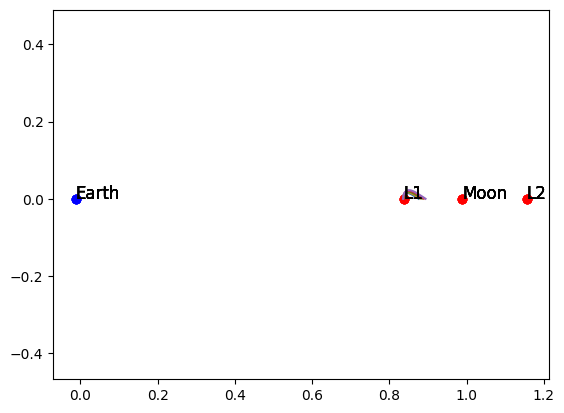

In [116]:

M_earth = 5.972e24
M_moon = 7.342e22

u2 = M_moon/(M_earth+M_moon)
u1 = 1-u2

stm_0 = np.eye(6)
stm_0 = stm_0.flatten()

L_f = 1/(383400)
V_f = 1/(1.071)
t_f = 2*np.pi/(2360320)

t_span = (0, 2*np.pi)
t = np.linspace(t_span[0], t_span[1], num=1000)

for x_0 in x_0s:

    x_0 = np.concatenate((x_0, stm_0))

    sol = solve_ivp(lunar_Orbit_DEQ_rotating, t_span, x_0,t_eval=t, dense_output='True', events=y_cross, rtol=1e-6, atol=1e-9 )


    plot_2body_scale(sol)


Solution for xe =  0.0010000000000000009  Not Found
Solution for xe =  0.0011250000000000426  Not Found


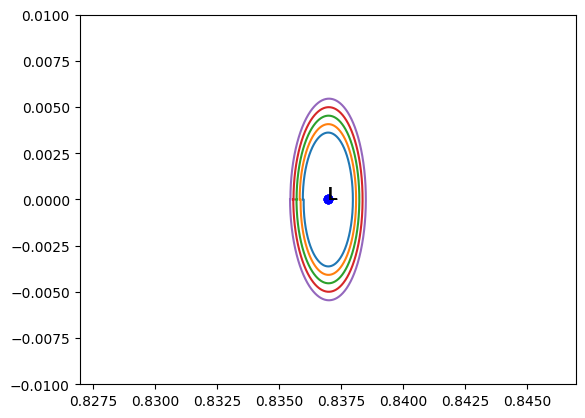

In [117]:
#Vary the parameter of interest (vy0)
#Calculate del_x(t) by getting the solution to the variational equations in 2.5.1
#Get the flow map
#Get the state transition matrix phi
d = 10e-8



xe = L1

for x_0 in x_0s:

    x_0 = np.concatenate((x_0, stm_0))
    vx = 1
    count = 0

    while abs(vx) > d:
        
        if x_0[4] > 0:
            y_cross.direction = -1
        elif x_0[4] < 0:
            y_cross.direction = 1
            
        t_span = (0, 2*np.pi)
        t = np.linspace(t_span[0], t_span[1], num=1000)    
        sol = solve_ivp(lunar_Orbit_DEQ_rotating, t_span, x_0,t_eval=t, dense_output='True', method = 'LSODA', events=y_cross, rtol=1e-10, atol=1e-14 )
        #Extract STM and Velocities
        stms = sol.y[6:,:]

        vy = sol.y[4,:][-1]
        vx = sol.y[3,:][-1]

        stm = stms[:,-1]

        #Reshape STM to matrix form for interpretable reference
        stm = np.reshape(stm, (6, 6))

        dvy_0 = ((stm[3,4] - (1/vy)*stm[2,4])**-1)*vx

        x_0[4] -= dvy_0

        count+=1


        if count > 30:
            print("Solution for xe = ", xe - x_0[0],  " Not Found")
            break
    t_span = (0, 2*sol.t[-1])
    t = np.linspace(t_span[0], t_span[1], num=1000)
    sol = solve_ivp(lunar_Orbit_DEQ_rotating, t_span, x_0,t_eval=t, dense_output='True', rtol=1e-10, atol=1e-14 )

    plot_xe_scale(sol, xe)

In [70]:
#Use the equillibrium point and desired Amplitudes (<<1) to generate initial guesses to periodic Orbits
xe = L1
As = np.linspace(.001,.0015,5)
As = [.00125, .0015]
x_0s = Analytical_Guesses(xe, As)


print(x_0s)

delta = x_0s[-1] - x_0s[-2]
x_0s = np.vstack((x_0s, x_0s[-1] + delta))
x_0s = x_0s[1:]

print(x_0s)

8.596526828371054
-4.955201126331229
[[0.83569394 0.         0.         0.         0.0532469  0.        ]
 [0.83544394 0.         0.         0.         0.06389628 0.        ]]
[[0.83544394 0.         0.         0.         0.06389628 0.        ]
 [0.83519394 0.         0.         0.         0.07454566 0.        ]]


2.692273085882027


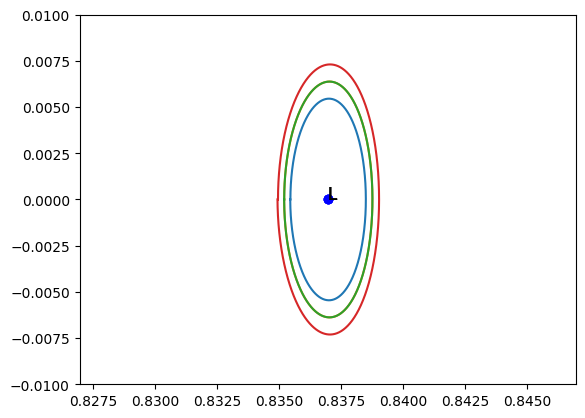

In [71]:
#Vary the parameter of interest (vy0)
#Calculate del_x(t) by getting the solution to the variational equations in 2.5.1
#Get the flow map
#Get the state transition matrix phi
d = 10e-10
xe = L1

for n in range(0,2):

    x_0s, x_1s, stm_0s, stm_1s, ts = Correct_to_PO(x_0s, xe, d)

    delta = x_0s[-1] - x_0s[-2]

    x_0s = np.vstack((x_0s, x_0s[-1] + delta))
    x_0s = x_0s[1:]
    
print(ts[-1])

In [276]:
for n in range(0,len(stm_0s)):
    stm_0 = np.reshape(stm_0s[n], (6, 6))
    stm_1 = np.reshape(stm_1s[n], (6, 6))
    print(np.round(stm_0, 2))
    print(np.linalg.det(stm_0))
    print(np.linalg.eigvals(stm_0))
    print(np.round(stm_1,0))
    print(np.linalg.det(stm_1))
    print(np.linalg.eigvals(stm_1))
    print(np.round(x_0s[n],4))
    print(np.round(x_1s[n],4))


[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
1.0
[1. 1. 1. 1. 1. 1.]
[[ 1.672e+03 -3.410e+02  0.000e+00  4.460e+02  1.820e+02  0.000e+00]
 [-6.820e+02  1.400e+02  0.000e+00 -1.820e+02 -7.400e+01  0.000e+00]
 [ 0.000e+00  0.000e+00  1.000e+00  0.000e+00  0.000e+00 -0.000e+00]
 [ 4.912e+03 -1.002e+03  0.000e+00  1.309e+03  5.340e+02  0.000e+00]
 [-2.063e+03  4.200e+02  0.000e+00 -5.500e+02 -2.230e+02  0.000e+00]
 [ 0.000e+00  0.000e+00  1.000e+00  0.000e+00  0.000e+00  1.000e+00]]
0.9999999995948826
[2.89638553e+03+0.j         3.45257905e-04+0.j
 7.99437928e-01+0.6007487j  7.99437928e-01-0.6007487j
 6.96113316e-01+0.71793193j 6.96113316e-01-0.71793193j]
[0.8349 0.     0.     0.     0.017  0.    ]
[ 0.8352  0.      0.     -0.      0.0148  0.    ]
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
1.0
[1. 1. 1. 1. 1. 1.]
[[ 1.669e+03 

## Integration by Multiple Shooting

In [12]:
#Use the equillibrium point and desired Amplitudes (<<1) to generate initial guesses to periodic Orbits
xe = L1
As = np.linspace(.001,.0015,5)

x_0s = Analytical_Guesses(xe, As)

8.596526828371054
-4.955201126331229


In [13]:
#Define functions (events) that trigger the solver to record or stop when the value of interest changes sign
def y_cross(t,x):
    
    return x[1]

#Trigger early stopping and only in the direction of positive to negative
y_cross.terminal = False

y_cross.direction = -1

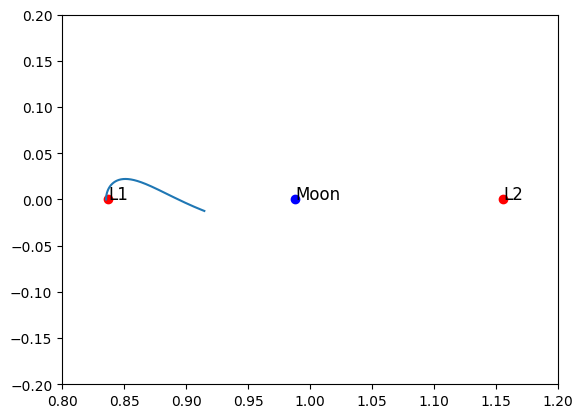

In [14]:

M_earth = 5.972e24
M_moon = 7.342e22

u2 = M_moon/(M_earth+M_moon)
u1 = 1-u2

stm_0 = np.eye(6)
stm_0 = stm_0.flatten()

L_f = 1/(383400)
V_f = 1/(1.071)
t_f = 2*np.pi/(2360320)

t_span = (0, 1)
t = np.linspace(t_span[0], t_span[1], num=1000)

for x_0 in x_0s:

    x_0 = np.concatenate((x_0, stm_0))

    sol = solve_ivp(lunar_Orbit_DEQ_rotating, t_span, x_0,t_eval=t, dense_output='True', events=y_cross, rtol=1e-6, atol=1e-9 )


plot_1body_scale(sol)


[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
Position Difference:  [-0.00078975 -0.00698207  0.        ]
Position Difference:  [-7.74844081e-07  1.44207216e-05  0.00000000e+00]
Position Difference:  [-1.25166522e-09 -1.73065794e-08  0.00000000e+00]
Position Difference:  [1.52033941e-12 2.72427133e-11 0.00000000e+00]
Position Difference:  [-2.44249065e-15 -4.28580782e-14  0.00000000e+00]
Position Difference:  [-1.11022302e-16  6.76542156e-17  0.00000000e+00]
Position Difference:  [0. 0. 0.]
segment 1 corrected
Position Difference:  [-0.00213847 -0.00650391  0.        ]
Position Difference:  [-4.97154417e-05 -9.04263877e-05  0.00000000e+00]
Position Difference:  [1.93303828e-07 3.65948745e-07 0.00000000e+00]
Position Difference:  [-2.92792457e-11 -5.80243791e-10  0.00000000e+00]
Position Difference:  [5.17363929e-14 9.42267098e-13 0.00000000e+00]
Position Difference:  [-3.33066907e-16 -1.53349555e-15  0.00000000e+00]
Pos

Position Difference:  [ 5.55111512e-16 -2.77555756e-17  0.00000000e+00]
Position Difference:  [-5.55111512e-16  2.77555756e-17  0.00000000e+00]
Position Difference:  [ 5.55111512e-16 -2.77555756e-17  0.00000000e+00]
Position Difference:  [-5.55111512e-16  2.77555756e-17  0.00000000e+00]
Position Difference:  [ 5.55111512e-16 -2.77555756e-17  0.00000000e+00]
Position Difference:  [-5.55111512e-16  2.77555756e-17  0.00000000e+00]
Position Difference:  [ 5.55111512e-16 -2.77555756e-17  0.00000000e+00]
Position Difference:  [-5.55111512e-16  2.77555756e-17  0.00000000e+00]
Position Difference:  [ 5.55111512e-16 -2.77555756e-17  0.00000000e+00]
Position Difference:  [-5.55111512e-16  2.77555756e-17  0.00000000e+00]
Position Difference:  [ 5.55111512e-16 -2.77555756e-17  0.00000000e+00]
Position Difference:  [-5.55111512e-16  2.77555756e-17  0.00000000e+00]
Position Difference:  [ 5.55111512e-16 -2.77555756e-17  0.00000000e+00]
Position Difference:  [-5.55111512e-16  2.77555756e-17  0.000000

Position Difference:  [4.44089210e-16 3.65493259e-18 0.00000000e+00]
Position Difference:  [-3.33066907e-16 -3.15531835e-18  0.00000000e+00]
Position Difference:  [4.44089210e-16 3.65493259e-18 0.00000000e+00]
Position Difference:  [-3.33066907e-16 -3.15531835e-18  0.00000000e+00]
Position Difference:  [4.44089210e-16 3.65493259e-18 0.00000000e+00]
Position Difference:  [-3.33066907e-16 -3.15531835e-18  0.00000000e+00]
Position Difference:  [4.44089210e-16 3.65493259e-18 0.00000000e+00]
Position Difference:  [-3.33066907e-16 -3.15531835e-18  0.00000000e+00]
Position Difference:  [4.44089210e-16 3.65493259e-18 0.00000000e+00]
Position Difference:  [-3.33066907e-16 -3.15531835e-18  0.00000000e+00]
Position Difference:  [4.44089210e-16 3.65493259e-18 0.00000000e+00]
Position Difference:  [-3.33066907e-16 -3.15531835e-18  0.00000000e+00]
Position Difference:  [4.44089210e-16 3.65493259e-18 0.00000000e+00]
Position Difference:  [-3.33066907e-16 -3.15531835e-18  0.00000000e+00]
Position Diff

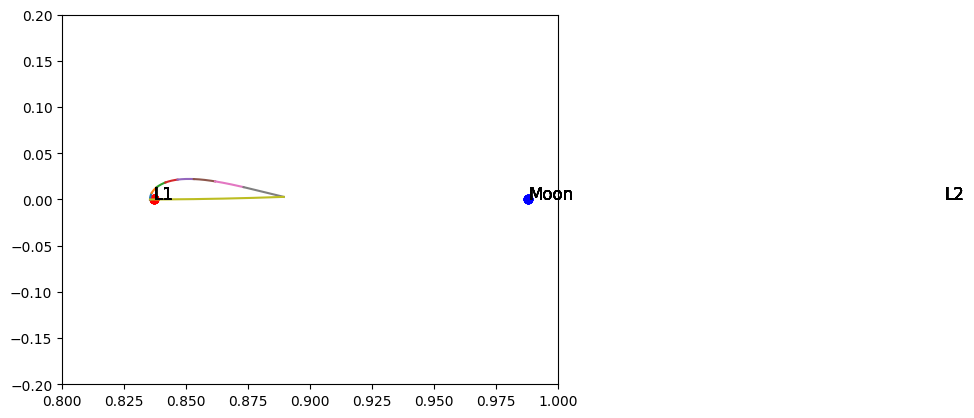

In [45]:

# def segments_from_reference_trajectory(sol, num_segments):
#     dt = sol.t[-1]/num_segments

#     segment_start_times = []
#     segment_states = []
#     for i in range(0,num_segments + 1):

#         segment_start_times.append(dt*i)
      
#         if np.any(sol.t == dt*i):

#             segment_states.append(sol.y[:,int(dt*i)])

#         else:

#             idx = np.searchsorted(sol.t, dt*i)

#             val1 = sol.y[:,idx-1]
#             val2 = sol.y[:,idx]

            
#             interp_ratio = dt*i - sol.t[idx-1]

#             interpolated_values = val1 + (val2 - val1)*interp_ratio

#             segment_states.append(interpolated_values)
            

#     return np.array(segment_states), np.array(segment_start_times)

def segments_from_reference_trajectory(sol, num_segments):
    dt = sol.t[-1]/(num_segments - 1)

    segment_start_times = []
    segment_states = []
    for i in range(0,num_segments - 1):

        segment_start_times.append(dt*i)
      


        idx = np.searchsorted(sol.t, dt*i)


        segment_states.append(sol.y[:,idx])
            
    segment_start_times.append(dt*(i+1))
    segment_states.append(sol.y[:,0])
    
    return np.array(segment_states), np.array(segment_start_times)

def Differential_Corrector_lvl1(segment_states, segment_start_times, tolerance):

    #The first level differential corrector takes a series of segment initial states from a pre-segmented
    #reference trajectory (initial guess) and propagates each trajectory. It then corrects each set of initial
    #conditions using L and the difference between the desired final position and actual final position. This
    #results in a trajectory continuous in position but discontinuous in velocities, to be corrected by the
    #level 2 differenital corrector
    
    #segment_states: [ndarray] - initial conditions (positions, velocities, stms) for each segment in the reference trajectory
    #segment_start_times: [ndarray] - t0s for each segment
    #tolerance: [float, int] - maximum allowable difference between desired and actual positions after correction
    new_segment_initial_states = []
    new_segment_final_states = []
    new_segment_start_times = []
    new_segment_initial_stms = []
    new_segment_final_stms = []


    for j in range(0, num_segments-1):
    

        t0 = segment_start_times[j]
        count = 0
        stm_I = np.eye(6,6)
        stm_I = stm_I.flatten()
        #until the position difference is below a desired threshold
        segment_states[j][6:] = stm_I

        dR = segment_states[j][0:3] - segment_states[j+1][0:3]
        
        dR_m = np.linalg.norm(dR)
        
        segment_states[j][3:6] = 0
        while dR_m > tolerance:
            
            #define timespan for jth segment
            t_span = (segment_start_times[j], segment_start_times[j + 1])
        
            t = np.linspace(t_span[0], t_span[1], num=2*50000)
            #integrate jth segment initial conditions


            sol = solve_ivp(lunar_Orbit_DEQ_rotating, t_span, segment_states[j],t_eval=t, dense_output='True', method = 'LSODA', rtol=1e-10, atol=1e-14 )    
            
            #get the desired and actual positions after integration
            r_reached = sol.y[0:3,-1]
            r0 = sol.y[0:3,0]
            r_desired = segment_states[j+1,0:3]
            
            #Extract relevant data from integrated trajectory
            Vf = sol.y[3:6,-1]
            V0 = sol.y[3:6,0]

            stms = sol.y[6:,:]

            stm = stms[:,-1]
            stmf = stm
            stm0 = stms[:,0]

            #Reshape STM to matrix form for interpretable reference
            stm = np.reshape(stm, (6, 6))
            #upper right portion of the stm
            stm_ur = stm[0:3, 3:6]


            #construct the L matrix, essentially the upper right state transition matrix concatenated with Vf
            L = np.hstack((stm_ur, Vf.reshape(-1, 1)))
            
            #preconstruct transpose of L for interpretibility
            LT = np.transpose(L)

            dR = r_reached - r_desired

            dR_m = np.linalg.norm(dR)
            print("Position Difference: ", dR)

            #Using the smallest euclidean norm of dR=L @ [dV, dtau]

            u = LT @ np.linalg.inv(L @ LT) @ dR

            dV = u[0:3]
            dtau = u[3]
            
            #Iteratively adjust the initial conditions to ensure convergence of the final position
            segment_start_times[j+1] -= dtau

            segment_states[j][3:6] -= dV
            count += 1
#             if count == 1:

#                 plot_xe_scale(sol, xe)                
            if count > 100:
                break

        #plot trajectories
#         plot_1body_scale(sol)

        new_segment_initial_states.append(segment_states[j][:6])
        new_segment_final_states.append(sol.y[:6,-1])
        new_segment_start_times.append(segment_start_times[j])
        new_segment_initial_stms.append(stm0)
        new_segment_final_stms.append(stmf)
        print("segment", j+1, "corrected")
        plot_1body_scale(sol)
        
    new_segment_start_times.append(segment_start_times[j+1])
    new_segment_initial_states.append(segment_states[j+1][:6])
#     Vfs.append(segment_states[0][3:6])    
    return new_segment_initial_states, new_segment_final_states, new_segment_initial_stms, new_segment_final_stms, new_segment_start_times



num_segments = 10

segment_states, segment_start_times = segments_from_reference_trajectory(sol, num_segments)

print(segment_start_times)


tolerance = 10e-18

segment_initial_states, segment_final_states, segment_initial_stms, segment_final_stms, segment_start_times \
= Differential_Corrector_lvl1(segment_states, segment_start_times, tolerance)



In [46]:

print(len(segment_initial_states))
for n in range(1,len(segment_initial_states)):
    delV = segment_initial_states[n][3:6] - segment_final_states[n-1][3:6]
    print(n+1)
    print("initial state: ", segment_initial_states[n][:6])
    print("final state: ", segment_final_states[n-1][3:6])
    print(delV)

print(initial_segment_states[0][:6])

9
10
2
initial state:  [0.83612923 0.00698977 0.         0.01257801 0.06165161 0.        ]
final state:  [0.01234174 0.06096483 0.        ]
[0.00023628 0.00068679 0.        ]
3
initial state:  [0.83818811 0.01332369 0.         0.02494693 0.05237457 0.        ]
final state:  [0.02499042 0.05289235 0.        ]
[-4.34993567e-05 -5.17776693e-04  0.00000000e+00]
4
initial state:  [0.84163958 0.01836008 0.         0.03705615 0.03740951 0.        ]
final state:  [0.03765868 0.03792267 0.        ]
[-0.00060252 -0.00051316  0.        ]
5
initial state:  [0.84655055 0.02148007 0.         0.04911513 0.01765675 0.        ]
final state:  [0.05082117 0.0173577  0.        ]
[-0.00170604  0.00029905  0.        ]
6
initial state:  [ 0.85309817  0.02208597  0.          0.0622336  -0.00603433  0.        ]
final state:  [ 0.06565637 -0.00801809  0.        ]
[-0.00342277  0.00198377  0.        ]
7
initial state:  [ 0.8616848   0.01958641  0.          0.07867361 -0.03343181  0.        ]
final state:  [ 0.08

In [51]:

for n in range(1,len(segment_initial_stms)):
    stm_0 = np.reshape(segment_initial_stms[n], (6, 6))
    stm_1 = np.reshape(segment_final_stms[n-1], (6, 6))
    print(n+1)

    print(np.linalg.det(stm_0))
    print(np.linalg.eigvals(stm_0))

    print(np.linalg.det(stm_1))
    print(np.linalg.eigvals(stm_1))


    
    print("initial stm: \n", np.round(stm_0, 2))
    print("final stm: \n", np.round(stm_1, 2))
    print()




2
1.0
[1.+0.00000000e+00j 1.+0.00000000e+00j 1.+0.00000000e+00j
 1.+0.00000000e+00j 1.+1.58973145e-18j 1.-1.58973145e-18j]
1.0000000000007163
[1.38504959+0.j         0.72199581+0.j         0.95994113+0.28020176j
 0.95994113-0.28020176j 0.97504805+0.2219939j  0.97504805-0.2219939j ]
initial stm: 
 [[ 1.  0.  0. -0. -0.  0.]
 [ 0.  1.  0.  0. -0.  0.]
 [ 0.  0.  1.  0.  0. -0.]
 [-0.  0.  0.  1. -0.  0.]
 [ 0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.]]
final stm: 
 [[ 1.07 -0.    0.    0.11  0.01  0.  ]
 [-0.01  0.97  0.   -0.01  0.11  0.  ]
 [ 0.    0.    0.98  0.    0.    0.11]
 [ 1.25 -0.09  0.    1.04  0.22  0.  ]
 [-0.16 -0.55  0.   -0.22  0.94  0.  ]
 [ 0.    0.   -0.45  0.    0.    0.98]]
3
1.0
[1.+0.00000000e+00j 1.+0.00000000e+00j 1.+1.57454534e-18j
 1.-1.57454534e-18j 1.+0.00000000e+00j 1.+0.00000000e+00j]
1.0000000000031894
[1.38225145+0.j         0.72345737+0.j         0.96066927+0.27769506j
 0.96066927-0.27769506j 0.97526837+0.22102399j 0.97526837-0.22102399j]
initial 

In [ ]:
def get_state_relationship_matrix(segment_initial_states, segment_final_states, segment_final_stms):

    stms = segment_final_stms

    # Initialize properly sized M matrix full of zeros. 
    # n is the number of segments
    M = np.zeros(((n-2)*3+3, (n-2)*4 +12))
    
    #starting at n = 1 in order to enable examination of (n-1) and n, iterate through all inner segments
    for n in range(1, num_segments):
            
            #the final state of trajectory n-1 
            patch2_minus_state = segment_final_states[n-1]          
            #the corresponding (co-located) initial state of trajectory n
            patch2_plus_state = segment_initial_states[n]
            
            #the accelerations of these two states based only on position and velocity 
            a2_minus = get_acceleration(patch2_minus_state)
            a2_plus  = get_acceleration(patch2_plus_state)            
            
            # state transition from state n-1 to n
            stm21 = stms[n-1]
            # state transition from state n to n-1 (backwards)
            stm12 = inv(stm21)
            # state transition from state n to n+1
            stm32 = stms[n]

            # by convention, v minus is the final state of a trajectory and v plus is the initial state of a trajectory
            # the number subscript denotes which trajectory segment the velocity is a part of
            # i.e. v1_plus is the initial velocity of the first segment
            v1_plus  = segment_initial_states[n-1][3:6]
            v2_minus = segment_final_states[n-1][3:6]
            v2_plus  = segment_initial_states[n][3:6]
            v3_minus = segment_final_states[n][3:6]
            

            #slice the relevant quadrant of stms
            B12 = stm12[0:3, 3:6]
            A12 = stm12[0:3, 0:3]
            B32 = stm32[0:3, 3:6] 
            A32 = stm32[0:3, 0:3] 
            
            #state variations (differentials)
            dVdR1_minus = - LA.inv(B12)
            dVdt1_minus = - LA.inv(B12) @ v1_plus
            dVdR2_minus = - LA.inv(B12) @ A12
            dVdt2_minus = a2_minus + LA.inv(B12) @ A12 @ v1_minus
            dVdR2_plus = - LA.inv(B32) @ A32
            dVdt2_plus = a2_plus + LA.inv(B32) @ A32 @ v1_plus
            dVdR3_plus = LA.inv(B32)
            dVdt3_plus = -LA.inv(B32) @ v3_minus
            
            #partials of delta V = V_plus - V_minus wrt position and time
            MR_minus = dVdR1_minus
            Mt_minus = dVdt1_minus
            MR = -dVdR2_minus + dVdR2_plus
            Mt = -dVdt2_minus + dVdt2_plus
            MR_plus = dVdR3_plus
            Mt_plus = dVdt3_plus
            
            Mn = [MR_minus, Mt_minus, MR, Mt,  MR_plus, Mt_plus]
            
            M[(n-1)*3:(n-1)*3+3, (n-1)*4:(n-1)*4+12] = Mn
            
    return M

In [ ]:
def Differential_Corrector_lvl2(segment_states, segment_start_times, tolerance):
    for j in range(0, num_segments-1):
    

        t0 = segment_start_times[j]
        count = 0
        stm_I = np.eye(6,6)
        stm_I = stm_I.flatten()
        #until the position difference is below a desired threshold
        segment_states[j][6:] = stm_I
        print(segment_states[j])
        dR = segment_states[j][0:3] - segment_states[j+1][0:3]
        
        dR_m = np.linalg.norm(dR)
        
        segment_states[j][3:6] = 0
        while dVm_m > tolerance:
            

            DR_lin[(3 * j):(3 * j + 3)] = DD[(4 * j):(4 * j + 3)]
            DT[j] = DD[(4 * j + 3)]


[[ 8.35443937e-01  8.35443968e-01  8.35444062e-01 ...  8.35429202e-01
   8.35428986e-01  8.35428832e-01]
 [ 0.00000000e+00  3.42199758e-05  6.84386081e-05 ... -6.45748131e-05
  -3.03031632e-05  3.97037566e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.31737561e-05  4.63464989e-05 ... -9.15191041e-05
  -6.86867502e-05 -4.58559831e-05]
 [ 1.26995952e-02  1.26993459e-02  1.26985981e-02 ...  1.27181729e-02
   1.27191225e-02  1.27195749e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


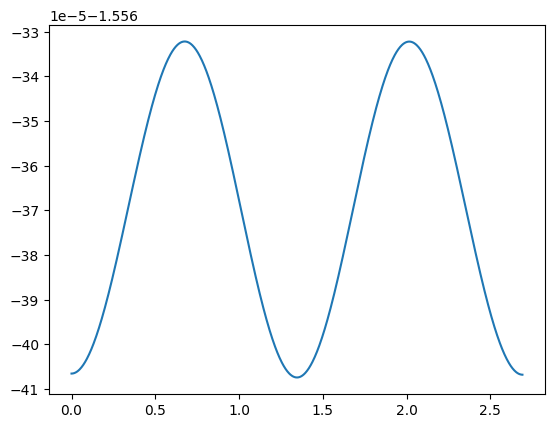

In [130]:
mu = M_moon/(M_earth+M_moon)

def Jacobi_Const(u,s):
    #This function computes the jacobi constant for
    #a given body in the rotating fixed frame of the CR3BP 
    #u: the mass ratio of the two primary bodies, M2/(M1+M2)
    #s: the object state, a list or ndarray structured as: [x, y, z, dx, dy, dz]
    #NOTE: s must be given in non-dimensional units for this formula to be valid
    
    #Extract state variables
    x = s[0]
    y = s[1]
    z = s[2]

    dx = s[3]
    dy = s[4]
    dz = s[5]

    #Compute the relative position magnitudes
    r1 = np.sqrt((x+u)**2 + y**2 + z**2)
    r2 = np.sqrt((x-1+u)**2 + y**2 + z**2)
    
    #Compute the jacobi constant
#     CJ = (x**2 + y**2) + (2*(1-u)/r1) + (2*u/r2) - dx**2 - dy**2 - dz**2
    CJ = .5*(np.linalg.norm(s[3:])**2) - (1-u)/r1 - u/r2 - .5*((1-u)*r1**2 + u*r2**2)
    return CJ


r_s = sol.y[:6,:]
print(r_s)
CJ = Jacobi_Const(mu,r_s)

plt.plot(sol.t, CJ)

In [6]:
sqrt(2)

1.4142135623730951

In [ ]:
# Step 1: Construct initial guess
initial_guess = construct_initial_guess()

# Step 2: Discretize into multiple arcs
arcs = discretize(initial_guess)

# Step 3: Set states at the beginning of all arcs as free variables
free_variables = get_initial_states(arcs)

# Step 4: Iteratively adjust free variables for continuity
while not converged:
    # Compute state trajectory for each arc
    for arc in arcs:
        trajectory = integrate(arc, free_variables)
        
        # Adjust free variables using Newton's method
        free_variables = adjust_variables(arc, free_variables, trajectory)
    
    # Check for convergence
    if within_tolerance(free_variables):
        break

# Step 5: Use pseudo-arclength continuation
while not termination_criteria_met():
    # Compute additional members along the periodic orbit family
    additional_member = pseudo_arclength_continuation(arcs, free_variables)
    
    if termination_criteria_met():
        break

# Final Result: Obtained periodic orbit
final_periodic_orbit = concatenate_arcs(arcs)

# Periodic Orbit Clustering 

## Construct Motion Primitive Library

## Construct Motion Primitive Graph

# Trajectories From Motion Primitives

## Identify Candidate Motion Primitive Sequences

## Construct an Initial Guess from a Primitive Sequence

## Recover a Continuous Trajectory

## Explore the Transfer Design Space

1.155659643984945
Position: (-0.0042589335558020835, 5.858527366170184e-11, 0.0)
Velocity: (0.023370889613458113, -7.90995053898605e-11, 0.0)
Position: (0.3464226537260711, 0.0, 0.0)
Velocity: (-1.90099365767615, 9.086631573480962e-09, 0.0)
Position: (0.41951056159355393, -0.03323771590389876, 0.0)
Velocity: (2.1052963064013617, 0.17784166865467868, 0.0)


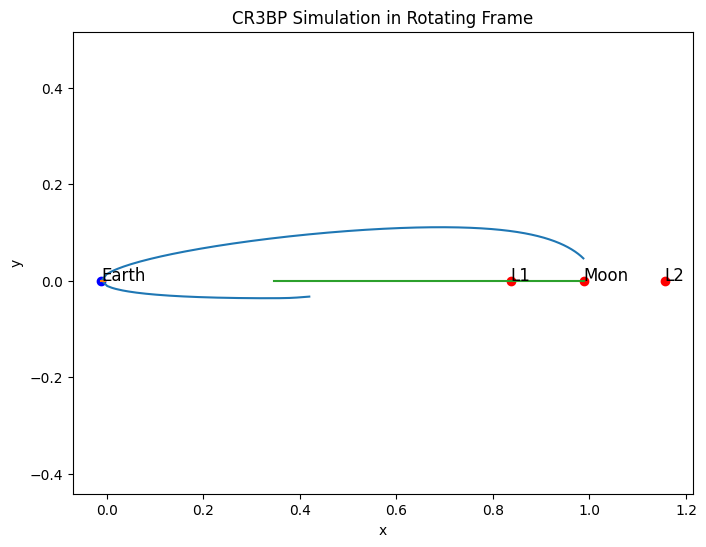

-0.736149082391391


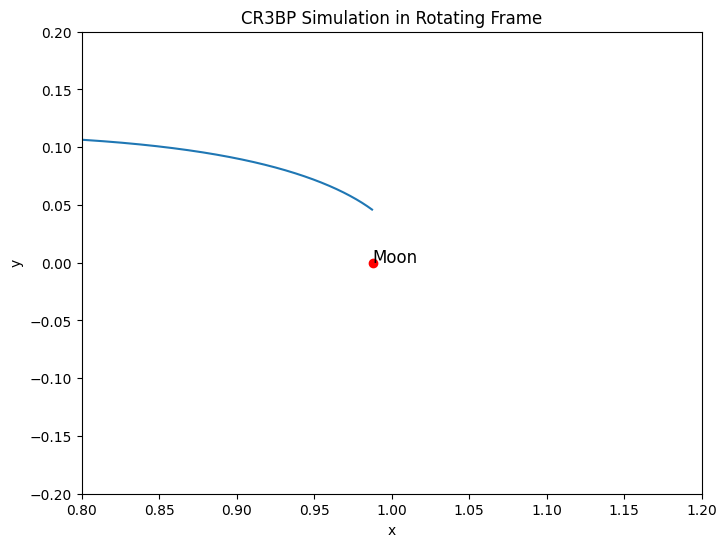

In [118]:
import rebound
print(xe)
# Define the parameters of the CR3BP
mu = M_moon/(M_earth+M_moon)
m0 = 1 - mu  # Mass of the primary body (Earth)

# Define the initial conditions
x0 =xe - A  # Initial x-coordinate
y0 = 0.0   # Initial y-coordinate
vx0 = -.5  # Initial velocity in x-direction
vy0 = .5  # Initial velocity in y-direction


# Define the initial conditions
x0 = m0  # Initial x-coordinate
y0 = .0455   # Initial y-coordinate
vx0 = -.5  # Initial velocity in x-direction
vy0 = .5 # Initial velocity in y-direction

# Create a rebound simulation
sim = rebound.Simulation()



# Set the units to be in the rotating frame
sim.move_to_com()
rot = rebound.Rotation.to_new_axes(newz=[0, 0, 1],newx=[m0,0,0]) # so it points along line of nodes between our original xy plane
sim.rotate(rot)

sim.integrator = "MERCURIUS"


sim.dt = .001

# Add the primary (Earth) and secondary (Moon) bodies
sim.add(m=m0, x = -mu)
sim.add(m=mu, x = m0)

# Add the small object (spacecraft)
sim.add(m=1e-10, x=x0, y=y0, vx=vx0, vy=vy0)


# Store the results in lists
times = []
x_values = []
y_values = []
ex_values = []
ey_values = []
mx_values = []
my_values = []

# Integrate the system
t_max = 1 # Set the end time of the simulation
while sim.t < t_max:
    m_vec = [sim.particles[1].x,sim.particles[1].y, 0 ]
    rot = rebound.Rotation.to_new_axes(newz=sim.angular_momentum(),newx=m_vec) # so it points along line of nodes between our original xy plane
    sim.rotate(rot)
    sim.integrate(sim.t + sim.dt)
    times.append(sim.t)
    m_vec = [sim.particles[1].x,sim.particles[1].y, 0 ]
    rot = rebound.Rotation.to_new_axes(newz=sim.angular_momentum(),newx=m_vec) # so it points along line of nodes between our original xy plane
    sim.rotate(rot)
    x_values.append(sim.particles[2].x)  # Index 2 corresponds to the small object (spacecraft)
    y_values.append(sim.particles[2].y)
    ex_values.append(sim.particles[0].x)  # Index 2 corresponds to the small object (spacecraft)
    ey_values.append(sim.particles[0].y)
    mx_values.append(sim.particles[1].x)  # Index 2 corresponds to the small object (spacecraft)
    my_values.append(sim.particles[1].y)
# Retrieve results
for particle in sim.particles:
    print(f"Position: ({particle.x}, {particle.y}, {particle.z})")
    print(f"Velocity: ({particle.vx}, {particle.vy}, {particle.vz})")
    
# Plot the trajectory
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values)
plt.plot(ex_values, ey_values)
plt.plot(mx_values, my_values)
plt.title('CR3BP Simulation in Rotating Frame')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-.2, 1.5)
# plt.ylim(-.2, .2)
# plt.axis('equal')
x_points = [-u2, u1, L1, L2]
y_points = [0, 0, 0 ,0]

labels = ['Earth', 'Moon', 'L1', 'L2']
plt.scatter(x_points[0], y_points[0], color='Blue')
plt.scatter(x_points[1:], y_points[1:], color='Red')
for label, x_val, y_val in zip(labels, x_points, y_points):
    plt.text(x_val, y_val, label, fontsize=12, ha='left')
    
plt.axis('equal')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values)
plt.title('CR3BP Simulation in Rotating Frame')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(.8, 1.2)
plt.ylim(-.2, .2)
# plt.ylim(-.2, .2)
# plt.axis('equal')
x_points = [-u2, u1]
y_points = [0, 0]


plt.scatter(u1, 0, color='Red')


plt.text(u1, 0, "Moon", fontsize=12, ha='left')

print(sim.particles[2].x - L2)